# Proyecto 4: Sistema de recomendación

- Martínez Ostoa Néstor
- Ramírez Bondi Alejandro
- Veleros Vega Luis

--- 

**Objetivo:** desarrollar un sistema de recomendación usando la base de datos que te fue asignada. De los métodos que se analizaron dentro de la unidad 4, selecciona el método de tu preferencia (basado en contenido, filtrado colaborativo o learning-to rank) es importante que justifiques el método de tu selección, por ejemplo en algunas base de datos es más apropiado usar filtrado colaborativo, sin embargo en algunas bases de datos este método no es el ideal. 

**Base de datos asignada:** [MovieLens 1M Dataset](https://grouplens.org/datasets/movielens/1m/)

- "*1 million ratings from 6000 users on 4000 movies*"

## Bibliotecas requeridas

In [ ]:
%%capture
!pip install movieposters

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
import matplotlib.pyplot as plt
import time
import movieposters as mp
import plotly.graph_objects as go
import plotly.figure_factory as ff
import random
import warnings
from scipy.sparse import coo_matrix
from numpy.linalg import norm
from wordcloud import WordCloud, STOPWORDS, get_single_color_func
from collections import defaultdict
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning:

urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!



## Exploración de datos

### Funciones auxiliares

In [ ]:
def read_data(url, names):
  return pd.read_csv(url, sep="::", encoding = 'unicode_escape', engine='python', names=names)

def basic_exploration(df, name):
  print(f"{name} data frame shape: {df.shape}\n")
  print(df.head())

def count_genres(movies_df):
  genres_dict = defaultdict(int)
  for _, row in movies_df.iterrows():
    for genre in row['Genres'].split('|'):
      genres_dict[genre] += 1
  return genres_dict

def sort_genres(movies_genres_dict):
  movies = list(movies_genres_dict.keys())
  count = list(movies_genres_dict.values())
  df = pd.DataFrame({'movie': movies, 'count': count})
  df = df.sort_values(by='count', ascending=False)
  return df

def plot_movie_genres(movies_df):
  movies_genres_dict = count_genres(movies_df)
  movies_genres_df = sort_genres(movies_genres_dict)
  fig = go.Figure()
  fig.add_trace(go.Bar(
      x = movies_genres_df.iloc[:3, :]['movie'],
      y = movies_genres_df.iloc[:3, :]['count'],
      marker_color='#3a0ca3'
  ))
  fig.add_trace(go.Bar(
      x = movies_genres_df.iloc[3:, :]['movie'],
      y = movies_genres_df.iloc[3:, :]['count'],
      marker_color='lightslategrey'
  ))
  fig.update_layout(
      title=dict(
          text="Movies' Genres Frequency"
      ),
      template='plotly_white', showlegend=False
  )
  fig.show()

def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

def plot_movies_word_cloud(movies_df, movie_genre):
  movies_df['Title'] = movies_df['Title'].fillna("").astype('str')
  text = ""
  for _, row in movies_df.iterrows():
    genres = row['Genres'].split('|')
    for g in genres:
      if g == movie_genre:
        text += row['Title'].lower()
        break

  sws = set(STOPWORDS)
  sws.add('la')
  sws.add('le')
  sws.add('de')
  sws.add('i')
  sws.add('ii')
  sws.add('iii')
  sws.add('iv')
  sws.add('v')
  sws.add('vi')

  color_to_words = {
      "#ffb703": ['man']
  }
  default_color = 'grey'
  grouped_color_func = GroupedColorFunc(color_to_words, default_color)

  wc = WordCloud(
      stopwords=sws, background_color='black', height=2000, width=4000
  ).generate(text)

  plt.imshow(wc.recolor(color_func=grouped_color_func), interpolation='bilinear')
  plt.axis('off')
  plt.show()

### Películas

In [ ]:
movies_url = "https://tinyurl.com/4yrxxwds"
movies_df = read_data(movies_url, names=["MovieID", "Title", "Genres"])
basic_exploration(movies_df, "Movies")

Movies data frame shape: (3883, 3)

   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy


In [ ]:
plot_movie_genres(movies_df)

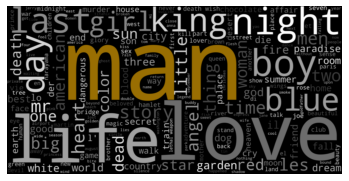

In [ ]:
plot_movies_word_cloud(movies_df, "Drama")

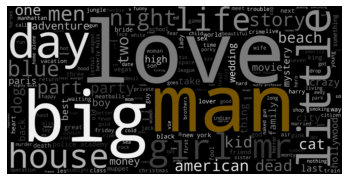

In [ ]:
plot_movies_word_cloud(movies_df, "Comedy")

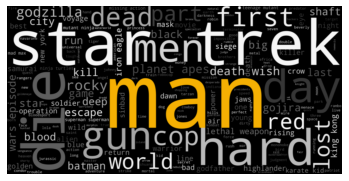

In [ ]:
plot_movies_word_cloud(movies_df, "Action")

### Funciones auxiliares

In [ ]:
def plot_exploration_for(users_df):

  fig = make_subplots(
      rows=2, cols=2,
      specs=[[{"type": "pie"}, {"type": "pie"}],
            [{"type": "xy"}, {"type": "xy"}]],
      subplot_titles=["", "Gender distribution<br>(Female:Purple, Male:Yellow)", "Occupation distribution", "Age distribution"]
  )


  fig.add_trace(go.Pie(
      labels=["Female", "Male"],
      values=[
              users_df[users_df['Gender'] == "F"].shape[0],
              users_df[users_df['Gender'] == "M"].shape[0]
      ], pull=[0.1, 0], marker_colors=['#3a0ca3', '#ffb703']
  ), row=1, col=2)

  age_df = pd.DataFrame(users_df[users_df['Gender']=='F']['Age'].value_counts())
  fig.add_trace(go.Bar(
      x = list(age_df.index),
      y = list(age_df['Age']),
      name='Female', xaxis="x2", yaxis="y2",
      marker_color='#3a0ca3'
  ), row=2, col=2)
  age_df = pd.DataFrame(users_df[users_df['Gender']=='M']['Age'].value_counts())
  fig.add_trace(go.Bar(
      x = list(age_df.index),
      y = list(age_df['Age']),
      name='Male', xaxis="x2", yaxis="y2",
      marker_color='#ffb703'
  ), row=2, col=2)

  occupation_df = pd.DataFrame(users_df[users_df['Gender']=='F']['Occupation'].value_counts())
  fig.add_trace(go.Bar(
      x = list(occupation_df.index),
      y = list(occupation_df['Occupation']),
      name = 'Female', xaxis="x3", yaxis="y3",
      marker_color = "#3a0ca3"
  ), row=2, col=1)
  occupation_df = pd.DataFrame(users_df[users_df['Gender']=='M']['Occupation'].value_counts())
  fig.add_trace(go.Bar(
      x = list(occupation_df.index),
      y = list(occupation_df['Occupation']),
      name = 'Male', xaxis="x3", yaxis="y3",
      marker_color = "#ffb703"
  ), row=2, col=1)
  
  layout = go.Layout(
      template='plotly_white',
      barmode='stack', showlegend=False
  )
  fig.update_layout(layout)
  fig.show()

### Usuarios

In [ ]:
users_url = "https://tinyurl.com/2vt5cbmu"
users_df = read_data(users_url, names=["UserID","Gender", "Age", "Occupation", "Zip-code"])
basic_exploration(users_df, "Users")

Users data frame shape: (6040, 5)

   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455


In [ ]:
plot_exploration_for(users_df)

### Funciones auxiliares

In [ ]:
def plot_ratings(ratings_df):
  sns.set(rc={"figure.figsize":(10, 6)})
  sns.set_theme()
  sns.set_style('whitegrid')
  data = ratings_df['Ratings'].fillna(ratings_df['Ratings'].median())
  #], pull=[0.1, 0], marker_colors=['#3a0ca3', '#ffb703'
  sns.distplot(data, color="#ffb703").set_title("Ratings distribution")

### Ratings

In [ ]:
ratings_url = "https://tinyurl.com/5esmznpn"
ratings_df = read_data(ratings_url, names=["UserID", "MovieID", "Ratings", "Timestamp"])
basic_exploration(ratings_df, "Ratings")

Ratings data frame shape: (1000209, 4)

   UserID  MovieID  Ratings  Timestamp
0       1     1193        5  978300760
1       1      661        3  978302109
2       1      914        3  978301968
3       1     3408        4  978300275
4       1     2355        5  978824291


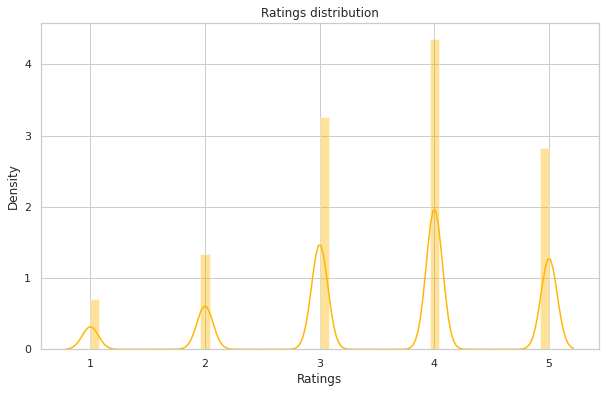

In [ ]:
plot_ratings(ratings_df)

### Funciones auxiliares

In [ ]:
def plot_joint_df(movies_df):
  # censo de genero de pelis
  genre_labels = set()
  for s in movies_df['Genres'].str.split('|').values:
      genre_labels = genre_labels.union(set(s))

  # Funcion que cuenta apariciones (numero de veces) de un genero
  def count_word(dataset, ref_col, census):
      keyword_count = dict()
      for s in census: 
          keyword_count[s] = 0
      for census_keywords in dataset[ref_col].str.split('|'):        
          if type(census_keywords) == float and pd.isnull(census_keywords): 
              continue        
          for s in [s for s in census_keywords if s in census]: 
              if pd.notnull(s): 
                  keyword_count[s] += 1
      #______________________________________________________________________
      # diccionario a lista ordenado por frecuencia
      keyword_occurences = []
      for k,v in keyword_count.items():
          keyword_occurences.append([k,v])
      keyword_occurences.sort(key = lambda x:x[1], reverse = True)
      return keyword_occurences, keyword_count

  # Al fin la lista de generos top ordenaods de forma descendente
  keyword_occurences, dum = count_word(movies_df, 'Genres', genre_labels)
  keyword_occurences[:5]

  #  genre wordcloud
  genres = dict()
  trunc_occurences = keyword_occurences[0:18]
  for s in trunc_occurences:
    genres[s[0]] = s[1]

  # Create the wordcloud
  genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
  genre_wordcloud.generate_from_frequencies(genres)

  # Plot the wordcloud
  f, ax = plt.subplots(figsize=(16, 8))
  plt.imshow(genre_wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()

## Visualización conjunta

In [ ]:
dataset = pd.merge(pd.merge(movies_df, ratings_df),users_df)
dataset[['Title','Genres','Ratings']].sort_values('Ratings', ascending=False).head()

,Title,Genres,Ratings
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5


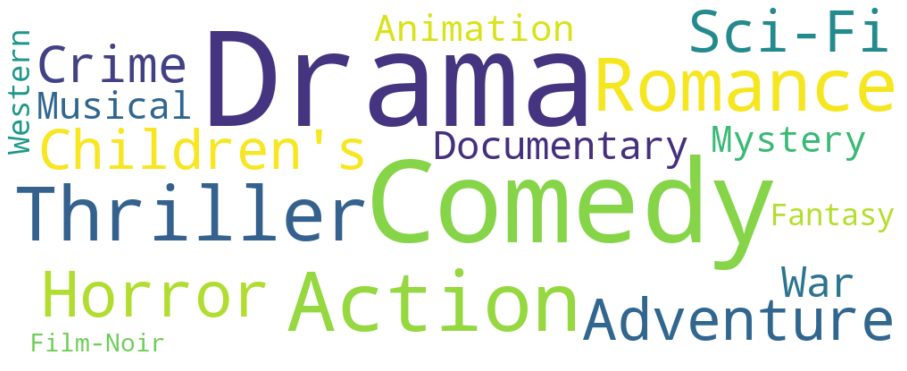

In [ ]:
plot_joint_df(movies_df)

## ¿Qué sistema de recomendacion nos conviene?

\\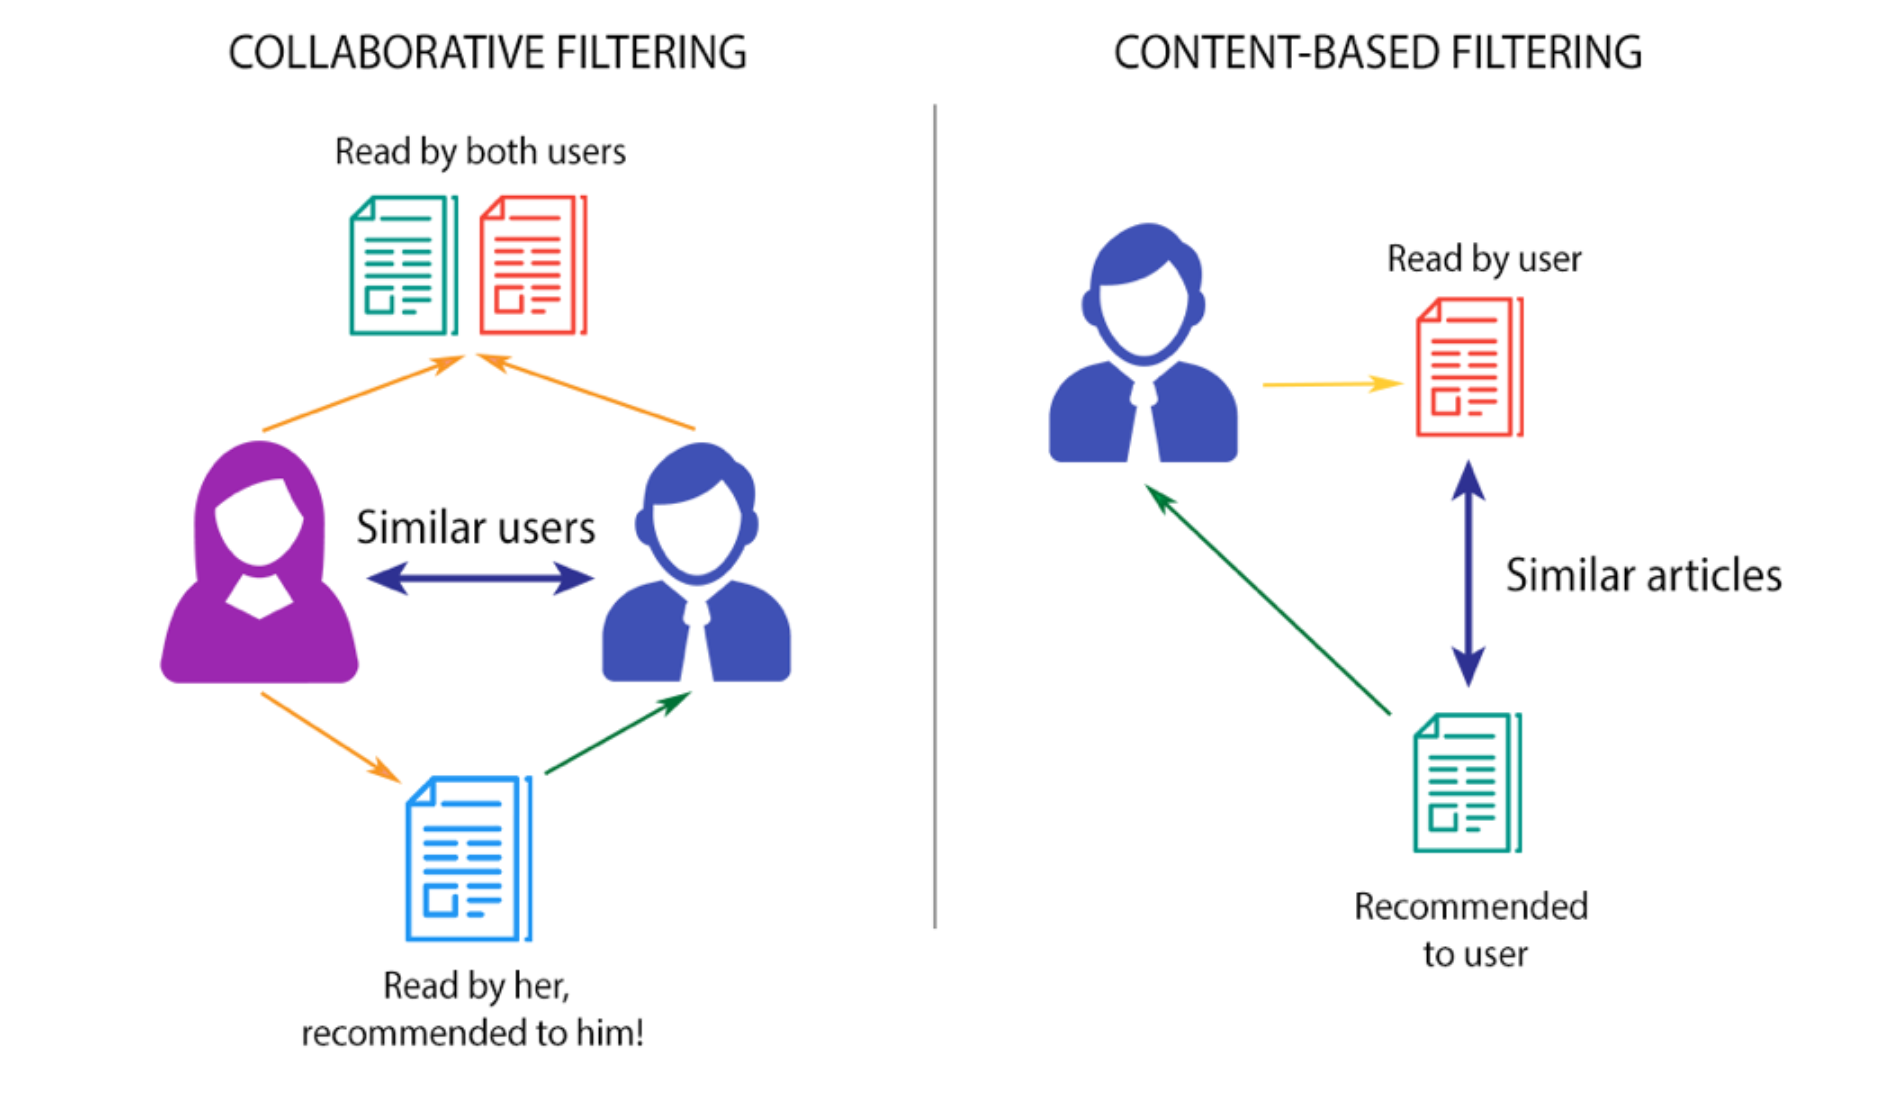

Ya vimos cuan importante es el género. Para construir un sistema de recomendación no podemos ignorar el atributo de género. Por lo cual, lo haremos basados en el set *movies*. Este sistema lo hará respecto al género, i.e. una similitud entre los posibles.

In [ ]:

movies_df['Genres'] = movies_df['Genres'].str.split('|')

movies_df['Genres'] = movies_df['Genres'].fillna("").astype('str')

la función TfidfVectorizer de scikit-learn transforma el texto en vectores de características que se pueden usar como entrada para el estimador.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_df['Genres'])
tfidf_matrix.shape

(3883, 127)

Dado que hemos utilizado el vectorizador TF-IDF, el cálculo del producto punto nos dará directamente la puntuación de similitud del coseno. Por lo tanto, usaremos linear_kernel de sklearn en lugar de cosine_similarities ya que es mucho más rápido.

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 ],
       [0.14193614, 1.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 ],
       [0.1056164 , 0.        , 0.1719888 , 1.        ]])

Ahora tenemos una matriz de similitud de coseno por pares para todas las películas en el conjunto de datos. El siguiente paso es escribir una función que devuelva las 20 películas más similares según la puntuación de similitud del coseno.

In [ ]:
# Build a 1-dimensional array with movie titles
titles = movies_df['Title']
indices = pd.Series(movies_df.index, index=movies_df['Title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
genre_recommendations('Good Will Hunting (1997)').head(20)

25                                        Othello (1995)
26                                   Now and Then (1995)
29     Shanghai Triad (Yao a yao yao dao waipo qiao) ...
30                                Dangerous Minds (1995)
35                               Dead Man Walking (1995)
39                       Cry, the Beloved Country (1995)
42                                    Restoration (1995)
52                                       Lamerica (1994)
54                                        Georgia (1995)
56                          Home for the Holidays (1995)
61                             Mr. Holland's Opus (1995)
66                                       Two Bits (1995)
77                            Crossing Guard, The (1995)
79          White Balloon, The (Badkonake Sefid ) (1995)
81                       Antonia's Line (Antonia) (1995)
82       Once Upon a Time... When We Were Colored (1995)
89                    Journey of August King, The (1995)
92                             

In [ ]:
genre_recommendations('Toy Story (1995)').head(20)

1050               Aladdin and the King of Thieves (1996)
2072                             American Tail, An (1986)
2073           American Tail: Fievel Goes West, An (1991)
2285                            Rugrats Movie, The (1998)
2286                                 Bug's Life, A (1998)
3045                                   Toy Story 2 (1999)
3542                                Saludos Amigos (1943)
3682                                   Chicken Run (2000)
3685       Adventures of Rocky and Bullwinkle, The (2000)
236                                 Goofy Movie, A (1995)
12                                           Balto (1995)
241                               Gumby: The Movie (1995)
310                             Swan Princess, The (1994)
592                                      Pinocchio (1940)
612                                Aristocats, The (1970)
700                               Oliver & Company (1988)
876     Land Before Time III: The Time of the Great Gi...
1010          

## Factor latente

- Estado del arte
- Reducción de dimensionalidad
  - Soluciona el problema de valores ausentes
- Basado en la correlación entre filas y columnas
- Factor latente: inferencia de patrones
  - Buena escalabilidad
  - Predicciones precisas
  - Flexibilidad
  - Métodos
    - SVD
    - PCA

In [ ]:
ratings_df = ratings_df[["UserID", "MovieID", "Ratings"]]
ratings_df

,UserID,MovieID,Ratings
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [ ]:
ratings_p_df = ratings_df.pivot(index="UserID", columns="MovieID", 
                                values="Ratings").fillna(0)
ratings_p_df

MovieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,4.0,0.0,3.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,4.0,3.0,0.0,4.0,3.0,4.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Matriz dispersa

In [ ]:
r = coo_matrix(ratings_p_df.values)
m, n = r.shape
print(f"Tamaño matriz dispersa: {r.shape}")

Tamaño matriz dispersa: (6040, 3706)


### Matriz de factores

In [ ]:
K = 3

In [ ]:
u = np.random.randn(m, K)
v = np.random.randn(K, n)
print(f"== Dimensiones de las matrices ==\n   U: {u.shape}\n   V: {v.shape}",
      end="\n\n")
print(f"== Valores ==\n   = U =\n{u}\n\n   = V =\n{v}")

== Dimensiones de las matrices ==
   U: (6040, 3)
   V: (3, 3706)

== Valores ==
   = U =
[[-0.89878015 -2.35295596  0.54257111]
 [-0.72121242  0.09742416  0.15778491]
 [ 1.55187272  1.54898298  0.65936866]
 ...
 [ 0.59488091 -0.8095339   0.6576563 ]
 [ 0.49085733  1.01895947 -2.05491058]
 [-1.78362834 -0.62448391  0.65832248]]

   = V =
[[-0.48331654 -2.47719303 -0.63166928 ...  0.13299126  0.02156752
  -0.74744222]
 [ 1.57620293  1.26583331 -0.01514279 ... -0.34850646  1.24225738
   1.97230808]
 [-0.3425566  -1.28302719 -2.07369618 ... -0.41020667  0.35943501
  -0.38771422]]


### Error y gradiente estocástico

In [ ]:
def mse_error(r, u, v, l=0.02):
  """Función que permite calcular el error cuadrático medio (MSE)."""
  ratings = r.data
  rows = r.row
  cols = r.col
  e = 0
  for i in range(len(ratings)):
    r = ratings[i]
    u_i = rows[i]
    v_i = cols[i]
    if r > 0:
      u_slice = u[u_i, :]
      v_slice = v[:, v_i]
      e += pow(r - np.dot(u_slice, v_slice), 2) + l * (pow(norm(u_slice), 2))
  return e


def stochastic_gradient_descent(r, k, l=0.02, gamma=0.001, steps=100):
  m, n = r.shape
  u = np.random.rand(m, k)
  v = np.random.rand(k, n)
  data_len = len(r.data)
  rmse = np.sqrt(mse_error(r, u, v, l) / len(r.data))
  print(f"Initial rmse: {rmse}\n")
  start_time = time.time()
  for step in range(steps):
    step_start_time = time.time()
    print(f"Step {step + 1} / {steps}")
    for i in range(data_len):
      r_i = r.data[i]
      u_i = r.row[i]
      v_i = r.col[i]
      if r_i > 0:
        e_i = r_i - np.dot(u[u_i, :], v[:, v_i])
        u[u_i, :] = u[u_i, :] + gamma * 2 * (e_i * v[:, v_i] - l * u[u_i, :])
        v[:, v_i] = v[:, v_i] + gamma * 2 * (e_i * u[u_i, :] - l * v[:, v_i])
    rmse = np.sqrt(mse_error(r, u, v, l) / data_len)
    step_end_time = time.time()
    print(f" \u23bf {step_end_time - step_start_time} s/step\
 - elapsed: {time.time() - start_time} s - rmse: {rmse}")
    if rmse < 0.5:
      break
  print(f"rmse: {rmse}")
  return u, v


u, v = stochastic_gradient_descent(r, K, l=0.001, gamma=0.007, steps=10)

Initial rmse: 3.0673830868461076

Step 1 / 10
 ⎿ 29.24172616004944 s/step - elapsed: 29.241743326187134 s - rmse: 2.3984184479355015
Step 2 / 10
 ⎿ 30.139639616012573 s/step - elapsed: 59.38218808174133 s - rmse: 0.9482742930393313
Step 3 / 10
 ⎿ 29.480370044708252 s/step - elapsed: 88.8627233505249 s - rmse: 0.9326514937622427
Step 4 / 10
 ⎿ 29.040173053741455 s/step - elapsed: 117.90314078330994 s - rmse: 0.9212809523302659
Step 5 / 10
 ⎿ 28.682122707366943 s/step - elapsed: 146.58598637580872 s - rmse: 0.9101382441179144
Step 6 / 10
 ⎿ 28.798583030700684 s/step - elapsed: 175.38480472564697 s - rmse: 0.901760255931398
Step 7 / 10
 ⎿ 28.85573434829712 s/step - elapsed: 204.24134635925293 s - rmse: 0.8963864251896952
Step 8 / 10
 ⎿ 28.9646635055542 s/step - elapsed: 233.2071135044098 s - rmse: 0.8931162409299627
Step 9 / 10
 ⎿ 30.403595685958862 s/step - elapsed: 263.61194801330566 s - rmse: 0.8912252154670491
Step 10 / 10
 ⎿ 30.44203805923462 s/step - elapsed: 294.0548183917999 s - r

### Predicciones

In [ ]:
pred_ratings = np.matmul(u, v)
pred_ratings_df = pd.DataFrame(np.round(pred_ratings, 4), 
                               columns=list(ratings_p_df.columns), 
                               index=list(ratings_p_df.index))
print(f"Dimensiones del DataFrame: {pred_ratings_df.shape}")
pred_ratings_df

Dimensiones del DataFrame: (6040, 3706)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,3913,3914,3915,3916,3917,3918,3919,3920,3921,3922,3923,3924,3925,3926,3927,3928,3929,3930,3931,3932,3933,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
1,4.3328,3.5834,3.2584,3.0793,3.4056,4.0366,3.7704,3.3046,2.8444,3.6727,4.0629,2.7413,3.7105,3.5140,3.1493,3.7261,4.2403,3.6506,2.4329,2.8743,3.5031,3.7317,3.1246,3.5988,3.1855,3.9896,3.1705,4.3479,3.6899,3.6245,3.4990,3.8328,2.3116,4.0744,3.2252,4.1530,3.1355,3.0381,3.8140,3.7545,...,3.3423,3.7700,3.9788,4.5157,2.9073,2.3389,2.3179,3.6861,2.4750,2.7009,2.5840,2.9230,3.6339,3.5023,3.7700,3.5326,4.0105,3.2692,2.0503,3.6700,2.3365,2.9499,3.0371,3.9453,3.3113,1.9890,2.1493,1.9976,2.2831,2.0586,3.2721,2.3068,1.7344,2.5278,3.6718,3.7869,3.6172,3.9180,4.1885,4.0502
2,3.6612,3.0594,2.8052,2.7218,2.9309,3.3084,3.3032,2.8222,2.3512,3.0085,3.4651,2.3341,3.2330,3.0253,2.7731,2.9826,3.7423,3.0168,1.7995,2.4281,2.9127,3.0886,2.5965,3.1399,2.5890,3.4681,2.6167,3.6896,3.0952,3.1574,2.9618,3.1729,1.9316,3.5119,2.7248,3.5458,2.5240,2.6310,3.2263,3.2585,...,2.8650,3.2905,3.3936,3.8587,2.1676,1.7037,1.8576,3.0821,2.1260,2.2930,2.1022,2.4868,3.0972,2.8702,3.0618,2.9594,3.4681,2.6790,1.7210,3.0854,1.9364,2.4105,2.6431,3.3600,2.7877,1.5907,1.7866,1.6807,1.9027,1.7219,2.7752,1.9200,1.4848,2.1286,3.0151,3.0866,2.9719,3.3211,3.5248,3.4897
3,4.1709,3.5667,3.2686,2.9186,3.4821,3.9267,3.6930,3.2481,2.9563,3.7452,4.0121,2.7340,3.5739,3.2497,3.1919,3.6602,3.9292,3.5804,2.6962,2.9467,3.3223,3.7892,3.2417,3.5286,2.9488,3.8261,3.2152,4.1726,3.3764,3.3219,3.5835,3.6143,2.3056,3.7795,3.0357,3.8848,3.1246,2.9750,3.6345,3.4639,...,3.1337,3.5647,3.8224,4.5624,2.9245,2.4150,2.3673,3.4589,2.2927,2.6089,2.5553,2.7928,3.3243,3.4663,3.7346,3.4313,3.7022,3.1475,1.9471,3.4290,2.3102,2.8428,2.8385,3.8137,3.2991,1.9948,2.1851,1.9741,2.2738,2.0266,3.0721,2.2677,1.7360,2.5748,3.6060,3.8258,3.3624,3.7619,4.0457,3.8905
4,4.4554,3.4566,3.0683,3.0501,3.1079,4.2471,3.5978,3.2495,2.6722,3.6029,3.9736,2.6457,3.6607,3.7297,2.8194,3.9767,4.3467,3.7580,2.3574,2.6816,3.7521,3.6363,2.9231,3.4486,3.6149,3.9743,3.1072,4.4662,4.0983,3.8358,3.2609,4.1584,2.2876,4.3006,3.4225,4.3867,3.2565,2.9477,3.9731,3.9570,...,3.5014,3.8123,4.0543,4.2472,3.2456,2.5780,2.3323,3.9779,2.6285,2.7471,2.6794,3.0117,3.9612,3.5946,3.9076,3.6254,4.2432,3.4904,2.1668,3.9569,2.3682,3.1557,3.1341,3.9920,3.2504,2.0624,2.0780,1.9869,2.2728,2.0752,3.4674,2.3452,1.6518,2.3942,3.8023,3.7940,4.0336,4.0275,4.3085,4.0732
5,2.8456,1.5809,1.1878,1.6606,0.9016,2.9497,1.5550,1.6698,0.9856,1.7871,1.9779,1.2121,1.9365,2.7243,0.6662,2.8941,2.7876,2.3909,1.0239,0.9477,2.8001,1.7418,1.0445,1.5302,3.2239,2.2104,1.5384,2.8444,3.4589,2.7828,1.1434,3.2418,1.2050,3.0780,2.4819,3.1375,2.1311,1.4104,2.6815,2.8227,...,2.4292,2.2877,2.4958,1.6201,2.6982,2.0449,1.3155,3.0540,1.9226,1.6735,1.7485,1.9456,3.1650,2.2496,2.5437,2.2877,3.0674,2.5629,1.5435,3.0335,1.4049,2.3319,2.0565,2.3767,1.6415,1.3371,0.9497,1.0794,1.2342,1.2038,2.5047,1.4141,0.6937,0.9544,2.4757,2.1089,3.4269,2.5720,2.7515,2.3666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.7642,2.4053,1.9720,2.4525,1.7342,3.6870,2.5140,2.4221,1.5713,2.4935,2.9012,1.8361,2.8451,3.5100,1.5081,3.4937,3.8513,3.0948,1.2984,1.5955,3.4729,2.4955,1.7035,2.4303,3.7459,3.1736,2.1688,3.7829,4.1746,3.6324,1.9386,3.9561,1.6858,3.9965,3.1501,4.0388,2.6629,2.1450,3.4864,3.6929,...,3.1703,3.2034,3.3768,2.6780,2.9826,2.2374,1.7110,3.7753,2.4709,2.2614,2.2100,2.5817,3.9305,2.9019,3.2119,3.0115,3.9817,3.1524,1.9581,3.7694,1.8664,2.8559,2.7772,3.2492,2.3550,1.6644,1.3941,1.5051,1.7018,1.6282,3.1943,1.8771,1.0999,1.5121

[Ajustamos][] el índice del DataFrame para que incluya los títulos de las películas.

[Ajustamos]: https://stackoverflow.com/questions/45636105/adding-values-in-new-column-based-on-indexes-with-pandas-in-python

In [ ]:
pred_ratings_df = pred_ratings_df.transpose()
pred_ratings_df["Title"] = pred_ratings_df.rename(index=movies_df.set_index("MovieID")["Title"]).index
pred_ratings_df.set_index("Title", inplace=True) # append=True
pred_ratings_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,6001,6002,6003,6004,6005,6006,6007,6008,6009,6010,6011,6012,6013,6014,6015,6016,6017,6018,6019,6020,6021,6022,6023,6024,6025,6026,6027,6028,6029,6030,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),4.3328,3.6612,4.1709,4.4554,2.8456,4.3620,4.0133,4.3779,3.6257,4.6649,3.3778,3.8928,3.4347,4.2769,3.8128,4.1903,4.5310,4.2217,4.1579,4.8153,3.7413,3.8636,3.7002,4.2186,3.8853,4.0406,4.2149,3.9190,3.7785,3.8783,3.9361,3.9999,3.5996,4.0660,3.8201,5.0072,4.3394,4.3675,4.3624,3.9772,...,4.2764,4.9902,4.5949,4.3589,5.0620,3.9066,3.4813,3.8499,3.7777,4.6239,4.3117,3.6561,4.0468,4.2493,3.9989,3.4402,4.0345,5.1830,4.2381,4.7433,3.6331,3.4838,4.0651,4.5706,4.2933,4.0215,4.3189,3.8305,4.7298,5.3078,3.3441,4.4036,4.1362,4.1515,3.5371,3.7642,3.8918,3.9950,4.1028,3.7889
Jumanji (1995),3.5834,3.0594,3.5667,3.4566,1.5809,4.0352,3.3002,3.2394,2.7081,4.1016,2.3278,2.9715,2.8042,3.2999,3.2592,3.2736,3.4151,3.1048,3.3238,3.8356,2.9049,2.6549,2.8658,3.1053,3.3363,3.4557,2.8743,2.8312,2.5845,3.2099,3.3987,2.9716,2.9837,3.2917,2.5483,3.8542,3.6995,3.5145,3.0967,3.0862,...,3.1060,3.9505,3.4188,3.5502,3.8903,3.1712,2.9797,3.3314,2.9937,3.8175,4.0050,2.5928,2.9213,2.9933,3.2065,2.3501,3.3489,3.8154,3.4044,3.6438,2.9798,2.5680,3.5427,3.9788,3.1659,2.8836,3.5978,3.0689,3.6286,3.9606,3.4128,3.1589,3.5535,3.1672,2.4217,2.4053,2.8768,3.1903,3.2669,2.3492
Grumpier Old Men (1995),3.2584,2.8052,3.2686,3.0683,1.1878,3.8337,2.9595,2.7956,2.3339,3.8291,1.9355,2.5884,2.5298,2.9482,2.9731,2.9458,2.9980,2.7130,2.9512,3.4509,2.5179,2.2093,2.4927,2.6963,3.0561,3.1948,2.4289,2.4557,2.1194,2.9068,3.1295,2.6296,2.6761,2.9489,2.1448,3.3888,3.4801,3.1668,2.6552,2.7524,...,2.6913,3.5486,3.0158,3.2038,3.4549,2.8907,2.7235,3.0718,2.6762,3.4369,3.7586,2.2439,2.6120,2.5959,2.8958,2.0059,3.0725,3.3333,3.0669,3.2254,2.6672,2.2334,3.2682,3.6953,2.7578,2.4774,3.2557,2.7516,3.2482,3.4409,3.2934,2.7546,3.2696,2.8074,2.0559,1.9720,2.4965,2.9177,2.9339,1.9147
Waiting to Exhale (1995),3.0793,2.7218,2.9186,3.0501,1.6606,3.5105,2.5596,2.7176,2.1611,3.5958,1.9359,2.3811,2.3561,3.1226,2.5596,3.1380,3.0640,2.9368,2.6276,3.4381,2.0688,2.2498,2.1332,2.7910,2.6786,3.0503,2.8130,2.7035,1.9828,2.6540,2.8061,2.9766,2.2463,2.6849,2.6296,3.2377,3.7813,3.0779,2.8969,2.8254,...,2.8872,3.5718,3.3305,3.0173,3.5641,2.9591,2.3721,2.7629,2.5930,3.0239,3.0679,2.6019,3.4248,3.1172,2.8963,2.4453,3.0604,3.5919,2.9953,3.2587,2.2941,2.3252,2.8800,3.4467,2.8982,2.6368,2.8867,2.6195,3.5519,3.3961,2.5260,3.2113,2.9650,2.9339,2.4112,2.4525,2.5342,3.2162,2.8892,2.5823
Father of the Bride Part II (1995),3.4056,2.9309,3.4821,3.1079,0.9016,4.1652,3.1251,2.7847,2.3513,4.0856,1.8530,2.6345,2.6377,2.9495,3.1823,2.9590,2.9874,2.6487,3.0729,3.5303,2.6196,2.1059,2.5774,2.6532,3.2682,3.3715,2.2548,2.3706,2.0413,3.0539,3.3423,2.5590,2.8447,3.0752,1.9443,3.4421,3.5943,3.2641,2.5452,2.7740,...,2.6163,3.6159,2.9497,3.3322,3.4657,2.9651,2.9120,3.2814,2.7439,3.6262,4.1503,2.1265,2.4365,2.4355,2.9679,1.8458,3.1901,3.2583,3.1569,3.2458,2.8161,2.1971,3.5087,3.9347,2.7093,2.3967,3.4419,2.8404,3.2245,3.4325,3.7487,2.6228,3.4809,2.8017,1.9083,1.7342,2.4691,2.9384,3.0064,1.6196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Meet the Parents (2000),3.7869,3.0866,3.8258,3.7940,2.1089,3.7645,3.8457,3.9030,3.3691,3.9926,3.0260,3.6107,3.0672,3.3843,3.6287,3.2625,3.7982,3.3565,3.9127,4.0331,3.7913,3.4097,3.6353,3.5328,3.6277,3.4339,3.2572,3.0895,3.5881,3.5174,3.5819,2.9743,3.5351,3.7289,2.7938,4.4643,3.0565,3.7454,3.5185,3.2616,...,3.4658,4.1428,3.5312,3.85

### Recomendaciones

Podemos hacer búsqueda por ID de usuario.

In [ ]:
ratings_df[ratings_df.UserID == 2153].merge(movies_df, on="MovieID")\
  .sort_values(by=["Ratings"], ascending=False).iloc[:5, 2:5]

,Ratings,Title,Genres
0,5,Who Framed Roger Rabbit? (1988),"['Adventure', 'Animation', 'Film-Noir']"
95,5,"Midsummer Night's Dream, A (1999)","['Comedy', 'Fantasy']"
97,5,"Truman Show, The (1998)",['Drama']
260,5,Pi (1998),"['Sci-Fi', 'Thriller']"
100,5,Clerks (1994),['Comedy']


In [ ]:
def get_user_recommendation(user_id, pred_ratings_df, n=5):
  user_top = pred_ratings_df[user_id].sort_values(ascending=False).iloc[:n]
  user_history = ratings_df[ratings_df.UserID == 2153]\
    .merge(movies_df, on="MovieID")\
    .sort_values(by=["Ratings"], ascending=False).iloc[:n, 2:5]
  print(f"Tudum 🎵\n\nHola {user_id}\n\nLas {n} películas que no puedes perderte:\
   \n{user_top.head()}\n\nSegún las películas que más te han gustado:\
   \n{user_history.head()}")
  return user_top


user_id = np.random.randint(users_df.shape[0])
user_top = get_user_recommendation(user_id, pred_ratings_df)

Tudum 🎵

Hola 2148

Las 5 películas que no puedes perderte:   
Title
Shawshank Redemption, The (1994)    5.2861
Sixth Sense, The (1999)             5.1124
Sanjuro (1962)                      5.0597
Schindler's List (1993)             5.0355
Saving Private Ryan (1998)          5.0288
Name: 2148, dtype: float64

Según las películas que más te han gustado:   
     Ratings  ...                                   Genres
0          5  ...  ['Adventure', 'Animation', 'Film-Noir']
95         5  ...                    ['Comedy', 'Fantasy']
97         5  ...                                ['Drama']
260        5  ...                   ['Sci-Fi', 'Thriller']
100        5  ...                               ['Comedy']

[5 rows x 3 columns]
